# Background

- Ultimately want to store all data in a single dataframe.
- The easiest option seems to be to match up filenames / groups (a.k.a. measurement labels) to the file that has all groups.
- In part, this should help with the question of time order.
- What to do with the groups that I don't have labels for?
- Also to add to each measurement:
    - Time of measurement (approx is fine)
    - SmarAct readout for both axes
    - Whether this is the home position or not (boolean)
- While doing the bookkeeping, start by adding the following column:
    - Candidate group label (list)

# Imports

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
from datetime import datetime, timedelta
from dateutil import parser
import numpy as np
import pandas as pd
import lmfit as lm
from scipy.interpolate import interp1d
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

from plotting import config_plots, get_label
config_plots()

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

from load_slow import load_data

In [3]:
raw_ddir = '/home/ckampa/Dropbox/LogFiles/survey_12-06-22/'
proc_ddir = 'data/'
plot_dir = 'plots/'

In [4]:
survey_ddir = '/home/ckampa/Dropbox/LogFiles/08Dec22_Survey_Data/' # day 2 & 3
#survey_ddir = '/home/ckampa/Dropbox/LogFiles/Dec22_Survey_Data/' # combined

# Find Times

In [5]:
# load data
data_file = raw_ddir+'2022-12-06 093302slow.txt'
cols = ['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'NMR [T]', 'NMR [FFT]',
        'SmarAct_Meas_Angle_1', 'SmarAct_Meas_Rotation_Angle_1', 'SmarAct_Meas_Angle_2', 'SmarAct_Meas_Rotation_Angle_2']

df_slow = load_data(data_file, header=cols).iloc[1:]
# skip to when we started  measuring
t0 = '12-06-2022 10:29:07'
df_slow = df_slow.query(f'"{t0}" <= Datetime')

## Day 1 Repeatability

In [6]:
# check validity of using the same angles for day 1 repeatability
#t0_1 = '12-06-2022 12:03:00' # when I set hold to 60
# t0_1 = '12-06-2022 13:15:00' # I think this is closer to when we came back from lunch
t0_1 = '12-06-2022 14:10:00' # time after fixing the laser tracker
# tf_1 = '12-06-2022 16:30:00' # I think we ended ~3:45, but adding some leeway
tf_1 = '12-06-2022 15:20:00' # this is before the axis 0 rotations
# after axis 0 rotations
t0_1b = '12-06-2022 15:45:55'
tf_1b = '12-06-2022 16:05:00'
#df_slow_day1 = df_slow.query(f'"{t0_1}" <= Datetime <= "{tf_1}"').copy()
df_slow_day1 = df_slow.query(f'("{t0_1}" <= Datetime <= "{tf_1}") or ("{t0_1b}" <= Datetime <= "{tf_1b}")').copy()

In [7]:
df_slow

,Time,Magnet Current [A],Magnet Voltage [V],NMR [T],NMR [FFT],SmarAct_Meas_Angle_1,SmarAct_Meas_Rotation_Angle_1,SmarAct_Meas_Angle_2,SmarAct_Meas_Rotation_Angle_2,seconds_delta,hours_delta,days_delta
Datetime,,,,,,,,,,,,
2022-12-06 10:29:08,12/6/2022 10:29:08 AM,0.0,0.0,0.0,0.0,357.999002,-1.0,346.997576,-1.0,3363.0,0.934167,0.038924
2022-12-06 10:30:35,12/6/2022 10:30:35 AM,0.0,0.0,0.0,0.0,358.007672,-1.0,346.997554,-1.0,3450.0,0.958333,0.039931
2022-12-06 10:30:36,12/6/2022 10:30:36 AM,0.0,0.0,0.0,0.0,358.007672,-1.0,346.997558,-1.0,3451.0,0.958611,0.039942
2022-12-06 10:31:36,12/6/2022 10:31:36 AM,0.0,0.0,0.0,0.0,358.007655,-1.0,346.997548,-1.0,3511.0,0.975278,0.040637
2022-12-06 10:32:36,12/6/2022 10:32:36 AM,0.0,0.0,0.0,0.0,358.007677,-1.0,346.997547,-1.0,3571.0,0.991944,0.041331
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08 11:23:55,12/8/2022 11:23:55 AM,0.0,0.0,0.0,0.0,357.999999,-1.0,347.000001,-1.0,179450.0,49.847222,2.076968
2022-12-08 11:24:55,12/8/2022 11:24:55 AM,0.0,0.0,0.0,0.0,358.000000,-1.0,346.999998,-1.0,179510.0,49.863889,2.077662
2022-12-08 11:25:55,12/8/2022 11:25:55 AM,0.0,0.0,0.0,0.0,357.999991,-1.0,346.999998,-1.0,179570.0,49.880556,2.078356


In [8]:
df_slow_day1

,Time,Magnet Current [A],Magnet Voltage [V],NMR [T],NMR [FFT],SmarAct_Meas_Angle_1,SmarAct_Meas_Rotation_Angle_1,SmarAct_Meas_Angle_2,SmarAct_Meas_Rotation_Angle_2,seconds_delta,hours_delta,days_delta
Datetime,,,,,,,,,,,,
2022-12-06 14:10:24,12/6/2022 2:10:24 PM,0.0,0.0,0.0,0.0,357.999999,-1.0,346.999992,-1.0,16639.0,4.621944,0.192581
2022-12-06 14:11:24,12/6/2022 2:11:24 PM,0.0,0.0,0.0,0.0,357.999999,-1.0,346.999992,-1.0,16699.0,4.638611,0.193275
2022-12-06 14:12:24,12/6/2022 2:12:24 PM,0.0,0.0,0.0,0.0,357.999997,-1.0,346.999992,-1.0,16759.0,4.655278,0.193970
2022-12-06 14:13:24,12/6/2022 2:13:24 PM,0.0,0.0,0.0,0.0,358.000084,-1.0,346.999992,-1.0,16819.0,4.671944,0.194664
2022-12-06 14:14:24,12/6/2022 2:14:24 PM,0.0,0.0,0.0,0.0,357.999995,-1.0,347.000000,-1.0,16879.0,4.688611,0.195359
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-06 16:00:55,12/6/2022 4:00:55 PM,0.0,0.0,0.0,0.0,357.999999,-1.0,346.999998,-1.0,23270.0,6.463889,0.269329
2022-12-06 16:01:55,12/6/2022 4:01:55 PM,0.0,0.0,0.0,0.0,357.999999,-1.0,346.999992,-1.0,23330.0,6.480556,0.270023
2022-12-06 16:02:55,12/6/2022 4:02:55 PM,0.0,0.0,0.0,0.0,357.999995,-1.0,346.999992,-1.0,23390.0,6.497222,0.270718


In [9]:
df_slow_day1[['SmarAct_Meas_Angle_1', 'SmarAct_Meas_Angle_2']].describe()

,SmarAct_Meas_Angle_1,SmarAct_Meas_Angle_2
count,89.000000,89.000000
mean,357.999995,346.999998
std,0.000040,0.000004
min,357.999799,346.999989
25%,357.999994,346.999998
50%,357.999995,346.999998
75%,357.999998,347.000000
max,358.000254,347.000012


In [10]:
df_slow_day1[['SmarAct_Meas_Angle_1', 'SmarAct_Meas_Angle_2']].max() - df_slow_day1[['SmarAct_Meas_Angle_1', 'SmarAct_Meas_Angle_2']].min()

SmarAct_Meas_Angle_1    0.000455
SmarAct_Meas_Angle_2    0.000023
dtype: float64

In [11]:
np.radians(2.7e-5)

4.7123889803846896e-07

In [12]:
np.radians(0.000455)

7.9412480965742e-06

In [13]:
timedelta()

datetime.timedelta(0)

In [28]:
times_repeat_day1 = [parser.parse('12-06-22 14:10')]
for i in range(6):
    times_repeat_day1.append(times_repeat_day1[-1] + timedelta(seconds=600))
# backlash test at the end of the day
#times_repeat_day1.append(parser.parse('12-06-22 15:46:55'))

In [29]:
times_repeat_day1

[datetime.datetime(2022, 12, 6, 14, 10),
 datetime.datetime(2022, 12, 6, 14, 20),
 datetime.datetime(2022, 12, 6, 14, 30),
 datetime.datetime(2022, 12, 6, 14, 40),
 datetime.datetime(2022, 12, 6, 14, 50),
 datetime.datetime(2022, 12, 6, 15, 0),
 datetime.datetime(2022, 12, 6, 15, 10)]

In [30]:
seconds_delta_day1 = [(i - df_slow.index[0]).total_seconds()+df_slow['seconds_delta'].iloc[0] for i in times_repeat_day1]

In [31]:
seconds_delta_day1

[16615.0, 17215.0, 17815.0, 18415.0, 19015.0, 19615.0, 20215.0]

In [32]:
SmarAct1_interp = interp1d(df_slow.seconds_delta.values, df_slow['SmarAct_Meas_Angle_1'].values, kind='nearest')
SmarAct2_interp = interp1d(df_slow.seconds_delta.values, df_slow['SmarAct_Meas_Angle_2'].values, kind='nearest')

In [33]:
SmarAct1_day1 = SmarAct1_interp(seconds_delta_day1)
SmarAct1_day1

array([357.999999, 357.999799, 357.999995, 357.999995, 357.999986,
       357.999934, 357.999995])

In [34]:
SmarAct1_day2 = SmarAct2_interp(seconds_delta_day1)
SmarAct1_day2

array([346.999992, 346.999992, 346.999993, 347.000003, 346.999998,
       346.999998, 347.000004])

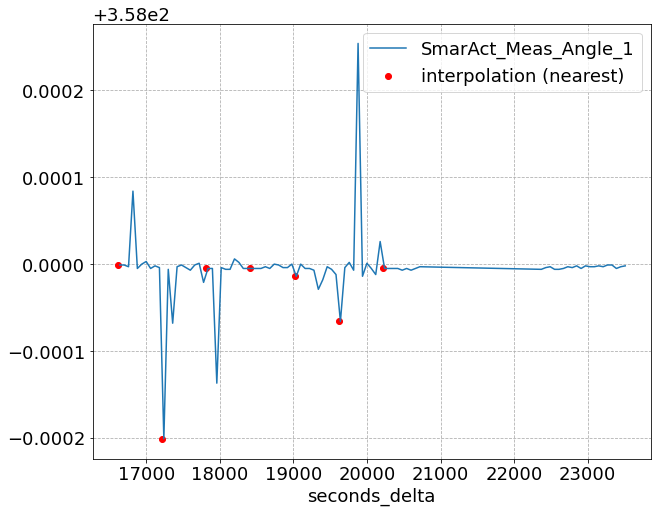

In [35]:
df_slow_day1.plot('seconds_delta', 'SmarAct_Meas_Angle_1')
plt.scatter(seconds_delta_day1, SmarAct1_day1, c='red', label='interpolation (nearest)')
plt.legend()

In [36]:
(df_slow_day1.index[-1] - df_slow_day1.index[0]).total_seconds() / 6 / 60

19.086111111111112

In [37]:
df_slow_day1.index[-1] - df_slow_day1.index[0]

Timedelta('0 days 01:54:31')

<AxesSubplot:xlabel='Datetime'>

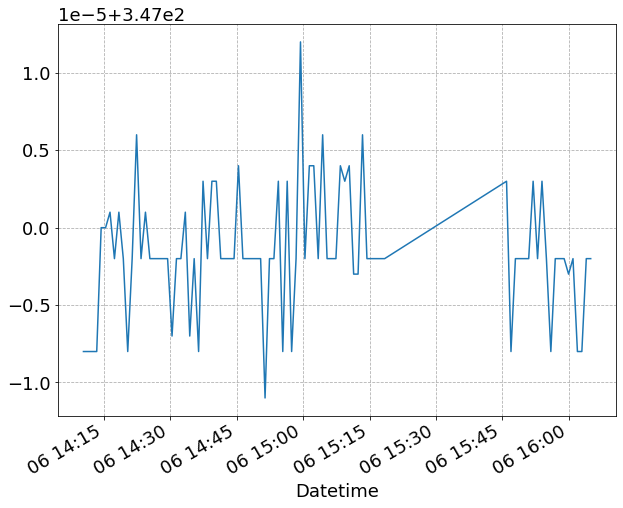

In [38]:
df_slow_day1['SmarAct_Meas_Angle_2'].plot()

In [39]:
#times_repeat_day1 = ['0']

In [40]:
# bins = np.arange()

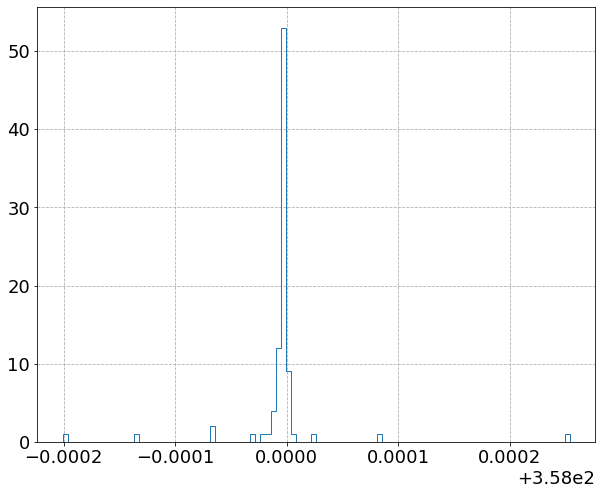

In [41]:
plt.hist(df_slow_day1['SmarAct_Meas_Angle_1'], bins=100, histtype='step');

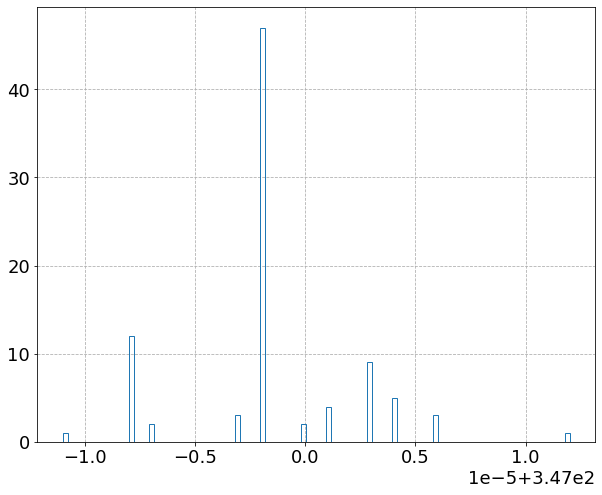

In [42]:
plt.hist(df_slow_day1['SmarAct_Meas_Angle_2'], bins=100, histtype='step');

- Upshot: should be fine to use one set of values (maybe the mean?) for all of the repeatability measurements.

## Slow Controls Plotly

In [122]:
data = [
    go.Scatter(
        x=df_slow.index,
        y=df_slow.SmarAct_Meas_Angle_1,
        mode='markers+lines',
        line=dict(color='blue'),
        marker=dict(color='blue'),
        name='SmarAct1 (Axis 0)',
    ),
    go.Scatter(
        x=df_slow.index,
        y=df_slow.SmarAct_Meas_Angle_2,
        mode='markers+lines',
        line=dict(color='orange'),
        marker=dict(color='orange'),
        name='SmarAct2 (Axis 1)',
    ),
]

layout = go.Layout(
    title='SmarAct Readout During Survey Work (12-06-22 - 12-08-22)',
    xaxis=dict(title='Datetime'),
    yaxis=dict(title='Measured Angle [deg]'),
    plot_bgcolor='rgb(240, 240, 240)',
)

fig = go.Figure(data=data, layout=layout)
fig.write_html(plot_dir+'SmarAct_vs_Datetime.html');

- Open in a separate tab to track times.

In [257]:
times_axis0_day1 = {
    '-3': '12-06-22 15:23:21',
    '-4': '12-06-22 15:26:25',
    '-5': '12-06-22 15:30:03',
    '-6': '12-06-22 15:32:58',
    '-7': '12-06-22 15:35:27',
    '-8': '12-06-22 15:37:51',
    '-9': '12-06-22 15:40:32',
    '-10': '12-06-22 15:43:16',
    '-2': '12-06-22 15:46:55', # backlash test at home
}

In [256]:
list(df.group.unique())

['Black Plate Repeatability - 17th Installation',
 'Black Plate Repeatability - 18th Installation',
 'Black Plate Repeatability - 19th Installation',
 'Black Plate Repeatability - 20th Installation',
 'Black Plate Repeatability - 21st Installation',
 'Black Plate Repeatability - 22nd Installation',
 'Black Plate Repeatability - 23rd Installation',
 'Black Plate Repeatability - 24th Installation',
 'Black Plate Repeatability - 25th Installation Home',
 'Black Plate Horizontal Rotation -4 Degrees B',
 'Black Plate Horizontal Rotation -6 Degrees B',
 'Black Plate Horizontal Rotation -8 Degrees B',
 'Black Plate Horizontal Rotation -10 Degrees B',
 'Black Plate Horizontal Rotation -0 Degrees B',
 'Black Plate Vertical Rotation -12 Degrees ',
 'Black Plate Vertical Rotation -11 Degrees',
 'Black Plate Vertical Rotation -10 Degrees',
 'Black Plate Vertical Rotation -5 Degrees',
 'Black Plate Vertical Rotation 0 Degrees',
 'Black Plate Vertical Rotation 15 Degrees',
 'Black Plate Vertical Rot

In [262]:
times_axis0_day2 = {
    'Rep 17': '12-07-22 08:11:31', # not putting stage in and out
    'Rep 18': '12-07-22 08:20:12',
    'Rep 19': '12-07-22 08:24:12',
    'Rep 20': '12-07-22 08:27:12',
    'Rep 21': '12-07-22 08:30:12',
    'Rep 22': '12-07-22 08:33:12',
    'Rep 23': '12-07-22 08:36:12',
    'Rep 24': '12-07-22 08:38:12',
    'Rep 25 home': '12-07-22 08:41:12',
    'H -4': '12-07-22 09:27:44',
    'H -6': '12-07-22 09:30:56',
    'H -8': '12-07-22 09:35:58',
    'H -10': '12-07-22 09:42:26',
    'H -0': '12-07-22 09:47:40', # really this is Home, so -2
    'V -12': '12-07-22 09:53:09',
    'V -11': '12-07-22 09:55:30',
    'V -10': '12-07-22 09:57:59',
    'V -5': '12-07-22 10:03:36',
    'V 0': '12-07-22 10:09:06',
    'V 15': '12-07-22 10:18:40',
    'V 30': '12-07-22 10:27:01',
    'V 60': '12-07-22 10:41:15',
    'V 90': '12-07-22 10:47:31', # SHIFT HAPPENED BETWEEN THESE TWO
    'V 135': '12-07-22 10:54:05', # SHIFT HAPPENED BETWEEN THESE TWO
    'V 180': '12-07-22 10:59:27',
    'V 225': '12-07-22 11:05:05',
    'V 270': '12-07-22 11:13:31',
    'V 315': '12-07-22 11:19:47', # lunch after this measurement
    'H 0': '12-07-22 13:32:36', # actually 0 this time
    'H 2': '12-07-22 13:39:23',
    'H 4': '12-07-22 13:42:48',
    'H 6': '12-07-22 13:45:43', # 5.87
    'H -5 V 0': '12-07-22 13:53:44',
    'H -10 V 0': '12-07-22 14:00:38',
    'H -5 V 90': '12-07-22 14:07:57',
    'H -10 V 90': '12-07-22 14:13:36',
    'H -5 V 180': '12-07-22 14:20:30',
    'H -10 V 180': '12-07-22 14:25:42',
    'H -5 V 270': '12-07-22 14:30:11',
    'H -10 V 270': '12-07-22 14:33:28',
    'Rep 25 check': '12-07-22 14:38:13',
    'Rep 25 check V 360': '12-07-22 14:43:41',
    'H 4 Check': '12-07-22 14:52:21',
    'H -8 Check': '12-07-22 14:55:45',
    'V 30 Check': '12-07-22 15:01:35',
    'H 0 Check': '12-07-22 15:04:27',
    'V 315 Check': '12-07-22 15:07:20',
    'V 180 Check': '12-07-22 15:08:41',
    'V 90 Check': '12-07-22 15:10:36',
    'V 315 Check': '12-07-22 15:07:20', # END OF DAY 2 (laser tracker stopped working)
    'Rep 25 home check': '12-08-22 08:39:12', # NEW LASER TRACKER STARTING HERE
    'Rep 25 home check 2': '12-08-22 08:41:12', # not sure if we did anything between the previous two?
    'V 135 Check': '12-08-22 08:49:16',
    'Rep 26 V 135': '12-08-22 08:56:16',
    'Rep 26 home ideal': '12-08-22 09:01:13',
    'Rep 27 home': '12-08-22 09:07:13',
    'Rep 28 home': '12-08-22 09:13:13',
    'Rep 29 home': '12-08-22 09:21:13',
    'H 0 C': '12-08-22 09:28:06',
    'H -4 C': '12-08-22 09:31:07',
    'H -6 C': '12-08-22 09:34:10',
    'H -8 C': '12-08-22 09:37:17',
    'H -9 C': '12-08-22 09:39:36',
    'Rep 29 home check': '12-08-22 09:42:11', # not removed, I think
    'V -12 C': '12-08-22 09:45:48',
    'V -11 C': '12-08-22 09:49:07',
    'V -10 C': '12-08-22 09:51:53',
    'V 0 C': '12-08-22 09:54:33',
    'H -5 V 0 C': '12-08-22 09:58:28',
    'V 90 C': '12-08-22 10:02:10',
    'H -5 V 90 C': '12-08-22 10:05:30',
    'V 135 C': '12-08-22 10:09:49',
    'Rep 29 home check 2': '12-08-22 10:15:06',
    'Rep 29 home check 3': '12-08-22 10:18:55',
}

In [263]:
list(df.group.unique())

['Black Plate Repeatability - 17th Installation',
 'Black Plate Repeatability - 18th Installation',
 'Black Plate Repeatability - 19th Installation',
 'Black Plate Repeatability - 20th Installation',
 'Black Plate Repeatability - 21st Installation',
 'Black Plate Repeatability - 22nd Installation',
 'Black Plate Repeatability - 23rd Installation',
 'Black Plate Repeatability - 24th Installation',
 'Black Plate Repeatability - 25th Installation Home',
 'Black Plate Horizontal Rotation -4 Degrees B',
 'Black Plate Horizontal Rotation -6 Degrees B',
 'Black Plate Horizontal Rotation -8 Degrees B',
 'Black Plate Horizontal Rotation -10 Degrees B',
 'Black Plate Horizontal Rotation -0 Degrees B',
 'Black Plate Vertical Rotation -12 Degrees ',
 'Black Plate Vertical Rotation -11 Degrees',
 'Black Plate Vertical Rotation -10 Degrees',
 'Black Plate Vertical Rotation -5 Degrees',
 'Black Plate Vertical Rotation 0 Degrees',
 'Black Plate Vertical Rotation 15 Degrees',
 'Black Plate Vertical Rot

In [264]:
len(list(df.group.unique()))

73

In [265]:
len(times_axis0_day2)

73

In [43]:
# dump to text file

In [ ]:
times_axis0_day1 = {
    '-3': '12-06-22 15:23:21',
    '-4': '12-06-22 15:26:25',
    '-5': '12-06-22 15:30:03',
    '-6': '12-06-22 15:32:58',
    '-7': '12-06-22 15:35:27',
    '-8': '12-06-22 15:37:51',
    '-9': '12-06-22 15:40:32',
    '-10': '12-06-22 15:43:16',
    '-2': '12-06-22 15:46:55', # backlash test at home
}

In [81]:
times_repeat_day1

[datetime.datetime(2022, 12, 6, 14, 10),
 datetime.datetime(2022, 12, 6, 14, 20),
 datetime.datetime(2022, 12, 6, 14, 30),
 datetime.datetime(2022, 12, 6, 14, 40),
 datetime.datetime(2022, 12, 6, 14, 50),
 datetime.datetime(2022, 12, 6, 15, 0),
 datetime.datetime(2022, 12, 6, 15, 10)]

In [88]:
times_axis0_day1_list = [
    ['Rep 10', '12-06-22 14:10:24'],
    ['Rep 11', '12-06-22 14:20:24'],
    ['Rep 12', '12-06-22 14:30:24'],
    ['Rep 13', '12-06-22 14:40:24'],
    ['Rep 14', '12-06-22 14:50:24'],
    ['Rep 15', '12-06-22 15:00:24'],
    ['Rep 16', '12-06-22 15:10:24'],
    ['H -3', '12-06-22 15:23:21'],
    ['H -4', '12-06-22 15:26:25'],
    ['H -5', '12-06-22 15:30:03'],
    ['H -6', '12-06-22 15:32:58'],
    ['H -7', '12-06-22 15:35:27'],
    ['H -8', '12-06-22 15:37:51'],
    ['H -9', '12-06-22 15:40:32'],
    ['H -10', '12-06-22 15:43:16'],
    ['H -2 backlash', '12-06-22 15:46:55'],
]

In [89]:
sorted([i.replace('.txt','') for i in os.listdir('/home/ckampa/Dropbox/LogFiles/06Dec22_Survey_Data/')])

['Black Plate Horizontal Rotation -10 Degrees',
 'Black Plate Horizontal Rotation -3 Degrees',
 'Black Plate Horizontal Rotation -4 Degrees',
 'Black Plate Horizontal Rotation -5 Degrees',
 'Black Plate Horizontal Rotation -6 Degrees',
 'Black Plate Horizontal Rotation -7 Degrees',
 'Black Plate Horizontal Rotation -8 Degrees',
 'Black Plate Horizontal Rotation -9 Degrees',
 'Black Plate Repeatability - 10th Installation Ideals',
 'Black Plate Repeatability - 11th Installation',
 'Black Plate Repeatability - 12th Installation',
 'Black Plate Repeatability - 13th Installation',
 'Black Plate Repeatability - 14th Installation',
 'Black Plate Repeatability - 15th Installation',
 'Black Plate Repeatability - 16th Installation',
 'Black Plate Repeatability - 16th Installation Backlash Test']

In [90]:
# time ordered groups, just do by hand.
groups_day1 = [
    'Black Plate Repeatability - 10th Installation Ideals',
    'Black Plate Repeatability - 11th Installation',
    'Black Plate Repeatability - 12th Installation',
    'Black Plate Repeatability - 13th Installation',
    'Black Plate Repeatability - 14th Installation',
    'Black Plate Repeatability - 15th Installation',
    'Black Plate Repeatability - 16th Installation',
    'Black Plate Horizontal Rotation -3 Degrees',
    'Black Plate Horizontal Rotation -4 Degrees',
    'Black Plate Horizontal Rotation -5 Degrees',
    'Black Plate Horizontal Rotation -6 Degrees',
    'Black Plate Horizontal Rotation -7 Degrees',
    'Black Plate Horizontal Rotation -8 Degrees',
    'Black Plate Horizontal Rotation -9 Degrees',
    'Black Plate Horizontal Rotation -10 Degrees',
    'Black Plate Repeatability - 16th Installation Backlash Test'
]

In [91]:
day_1_to_file = ""

for l, group in zip(times_axis0_day1_list, groups_day1):
    g_short = l[0]
    dt = l[1]
    day_1_to_file += f'"{group}","{dt}"\n'
    print(f'Matching "{g_short}" -- "{group}"')

Matching "Rep 10" -- "Black Plate Repeatability - 10th Installation Ideals"
Matching "Rep 11" -- "Black Plate Repeatability - 11th Installation"
Matching "Rep 12" -- "Black Plate Repeatability - 12th Installation"
Matching "Rep 13" -- "Black Plate Repeatability - 13th Installation"
Matching "Rep 14" -- "Black Plate Repeatability - 14th Installation"
Matching "Rep 15" -- "Black Plate Repeatability - 15th Installation"
Matching "Rep 16" -- "Black Plate Repeatability - 16th Installation"
Matching "H -3" -- "Black Plate Horizontal Rotation -3 Degrees"
Matching "H -4" -- "Black Plate Horizontal Rotation -4 Degrees"
Matching "H -5" -- "Black Plate Horizontal Rotation -5 Degrees"
Matching "H -6" -- "Black Plate Horizontal Rotation -6 Degrees"
Matching "H -7" -- "Black Plate Horizontal Rotation -7 Degrees"
Matching "H -8" -- "Black Plate Horizontal Rotation -8 Degrees"
Matching "H -9" -- "Black Plate Horizontal Rotation -9 Degrees"
Matching "H -10" -- "Black Plate Horizontal Rotation -10 Degre

In [93]:
print(day_1_to_file)

"Black Plate Repeatability - 10th Installation Ideals","12-06-22 14:10:24"
"Black Plate Repeatability - 11th Installation","12-06-22 14:20:24"
"Black Plate Repeatability - 12th Installation","12-06-22 14:30:24"
"Black Plate Repeatability - 13th Installation","12-06-22 14:40:24"
"Black Plate Repeatability - 14th Installation","12-06-22 14:50:24"
"Black Plate Repeatability - 15th Installation","12-06-22 15:00:24"
"Black Plate Repeatability - 16th Installation","12-06-22 15:10:24"
"Black Plate Horizontal Rotation -3 Degrees","12-06-22 15:23:21"
"Black Plate Horizontal Rotation -4 Degrees","12-06-22 15:26:25"
"Black Plate Horizontal Rotation -5 Degrees","12-06-22 15:30:03"
"Black Plate Horizontal Rotation -6 Degrees","12-06-22 15:32:58"
"Black Plate Horizontal Rotation -7 Degrees","12-06-22 15:35:27"
"Black Plate Horizontal Rotation -8 Degrees","12-06-22 15:37:51"
"Black Plate Horizontal Rotation -9 Degrees","12-06-22 15:40:32"
"Black Plate Horizontal Rotation -10 Degrees","12-06-22 15:43:

In [129]:
times_axis0_day2_list = [
    ['Rep 17', '12-07-22 08:11:31'], # not putting stage in and out
    ['Rep 18', '12-07-22 08:20:12'],
    ['Rep 19', '12-07-22 08:24:12'],
    ['Rep 20', '12-07-22 08:27:12'],
    ['Rep 21', '12-07-22 08:30:12'],
    ['Rep 22', '12-07-22 08:33:12'],
    ['Rep 23', '12-07-22 08:36:12'],
    ['Rep 24', '12-07-22 08:38:12'],
    ['Rep 25 home', '12-07-22 08:41:12'],
    ['H -4', '12-07-22 09:27:44'],
    ['H -6', '12-07-22 09:30:56'],
    ['H -8', '12-07-22 09:35:58'],
    ['H -10', '12-07-22 09:42:26'],
    ['H -0', '12-07-22 09:47:40'], # really this is Home, so -2
    ['V -12', '12-07-22 09:53:09'],
    ['V -11', '12-07-22 09:55:30'],
    ['V -10', '12-07-22 09:57:59'],
    ['V -5', '12-07-22 10:03:36'],
    ['V 0', '12-07-22 10:09:06'],
    ['V 15', '12-07-22 10:18:40'],
    ['V 30', '12-07-22 10:27:01'],
    ['V 60', '12-07-22 10:41:15'],
    ['V 90', '12-07-22 10:47:31'], # SHIFT HAPPENED BETWEEN THESE TWO
    ['V 135', '12-07-22 10:54:05'], # SHIFT HAPPENED BETWEEN THESE TWO
    ['V 180', '12-07-22 10:59:27'],
    ['V 225', '12-07-22 11:05:05'],
    ['V 270', '12-07-22 11:13:31'],
    ['V 315', '12-07-22 11:19:47'], # lunch after this measurement
    ['H 0', '12-07-22 13:32:36'], # actually 0 this time
    ['H 2', '12-07-22 13:39:23'],
    ['H 4', '12-07-22 13:42:48'],
    ['H 6', '12-07-22 13:45:43'], # 5.87
    ['H -5 V 0', '12-07-22 13:53:44'],
    ['H -10 V 0', '12-07-22 14:00:38'],
    ['H -5 V 90', '12-07-22 14:07:57'],
    ['H -10 V 90', '12-07-22 14:13:36'],
    ['H -5 V 180', '12-07-22 14:20:30'],
    ['H -10 V 180', '12-07-22 14:25:42'],
    ['H -5 V 270', '12-07-22 14:30:11'],
    ['H -10 V 270', '12-07-22 14:33:28'],
    ['Rep 25 check', '12-07-22 14:38:13'],
    ['Rep 25 check V 360', '12-07-22 14:43:41'],
    ['H 4 Check', '12-07-22 14:52:21'],
    ['H -8 Check', '12-07-22 14:55:45'],
    ['V 30 Check', '12-07-22 15:01:35'],
    ['H 0 Check', '12-07-22 15:04:27'],
    ['V 315 Check', '12-07-22 15:07:20'],
    ['V 180 Check', '12-07-22 15:08:41'],
    ['V 90 Check', '12-07-22 15:10:36'], # END OF DAY 2 (laser tracker stopped working)
#     ['V 315 Check', '12-07-22 15:07:20'], # END OF DAY 2 (laser tracker stopped working)
    ['Rep 25 home check', '12-08-22 08:39:12'], # NEW LASER TRACKER STARTING HERE
    ['Rep 25 home check 2', '12-08-22 08:41:12'], # not sure if we did anything between the previous two?
    ['V 135 Check', '12-08-22 08:49:16'],
    ['Rep 26 V 135', '12-08-22 08:56:16'],
    ['Rep 26 home ideal', '12-08-22 09:01:13'],
    ['Rep 27 home', '12-08-22 09:07:13'],
    ['Rep 28 home', '12-08-22 09:13:13'],
    ['Rep 29 home', '12-08-22 09:21:13'],
    ['H 0 C', '12-08-22 09:28:06'],
    ['H -4 C', '12-08-22 09:31:07'],
    ['H -6 C', '12-08-22 09:34:10'],
    ['H -8 C', '12-08-22 09:37:17'],
    ['H -9 C', '12-08-22 09:39:36'],
    ['Rep 29 home check', '12-08-22 09:42:11'], # not removed, I think
    ['V -12 C', '12-08-22 09:45:48'],
    ['V -11 C', '12-08-22 09:49:07'],
    ['V -10 C', '12-08-22 09:51:53'],
    ['V 0 C', '12-08-22 09:54:33'],
    ['H -5 V 0 C', '12-08-22 09:58:28'],
    ['V 90 C', '12-08-22 10:02:10'],
    ['H -5 V 90 C', '12-08-22 10:05:30'],
    ['V 135 C', '12-08-22 10:09:49'],
    ['Rep 29 home check 2', '12-08-22 10:15:06'],
    ['Rep 29 home check 3', '12-08-22 10:18:55'],
]

In [132]:
len(list(df.group.unique()))

73

In [133]:
len(times_axis0_day2_list)

73

In [134]:
day_2_to_file = ""

for l, group in zip(times_axis0_day2_list, list(df.group.unique())):
    g_short = l[0]
    dt = l[1]
    day_2_to_file += f'"{group}","{dt}"\n'
    print(f'Matching "{g_short}" -- "{group}"')

Matching "Rep 17" -- "Black Plate Repeatability - 17th Installation"
Matching "Rep 18" -- "Black Plate Repeatability - 18th Installation"
Matching "Rep 19" -- "Black Plate Repeatability - 19th Installation"
Matching "Rep 20" -- "Black Plate Repeatability - 20th Installation"
Matching "Rep 21" -- "Black Plate Repeatability - 21st Installation"
Matching "Rep 22" -- "Black Plate Repeatability - 22nd Installation"
Matching "Rep 23" -- "Black Plate Repeatability - 23rd Installation"
Matching "Rep 24" -- "Black Plate Repeatability - 24th Installation"
Matching "Rep 25 home" -- "Black Plate Repeatability - 25th Installation Home"
Matching "H -4" -- "Black Plate Horizontal Rotation -4 Degrees B"
Matching "H -6" -- "Black Plate Horizontal Rotation -6 Degrees B"
Matching "H -8" -- "Black Plate Horizontal Rotation -8 Degrees B"
Matching "H -10" -- "Black Plate Horizontal Rotation -10 Degrees B"
Matching "H -0" -- "Black Plate Horizontal Rotation -0 Degrees B"
Matching "V -12" -- "Black Plate Vert

In [135]:
print(day_2_to_file)

"Black Plate Repeatability - 17th Installation","12-07-22 08:11:31"
"Black Plate Repeatability - 18th Installation","12-07-22 08:20:12"
"Black Plate Repeatability - 19th Installation","12-07-22 08:24:12"
"Black Plate Repeatability - 20th Installation","12-07-22 08:27:12"
"Black Plate Repeatability - 21st Installation","12-07-22 08:30:12"
"Black Plate Repeatability - 22nd Installation","12-07-22 08:33:12"
"Black Plate Repeatability - 23rd Installation","12-07-22 08:36:12"
"Black Plate Repeatability - 24th Installation","12-07-22 08:38:12"
"Black Plate Repeatability - 25th Installation Home","12-07-22 08:41:12"
"Black Plate Horizontal Rotation -4 Degrees B","12-07-22 09:27:44"
"Black Plate Horizontal Rotation -6 Degrees B","12-07-22 09:30:56"
"Black Plate Horizontal Rotation -8 Degrees B","12-07-22 09:35:58"
"Black Plate Horizontal Rotation -10 Degrees B","12-07-22 09:42:26"
"Black Plate Horizontal Rotation -0 Degrees B","12-07-22 09:47:40"
"Black Plate Vertical Rotation -12 Degrees ","1

In [136]:
# try loading
#df_times = pd.read_csv('data/group_time_table_12-06-22_to_12-08-22.txt', names=['group', 'Time'])
df_times = pd.read_csv('data/group_time_table_12-06-22_to_12-08-22.txt')

In [137]:
df_times

,Group,Time
0,Black Plate Repeatability - 10th Installation ...,12-06-22 14:10:24
1,Black Plate Repeatability - 11th Installation,12-06-22 14:20:24
2,Black Plate Repeatability - 12th Installation,12-06-22 14:30:24
3,Black Plate Repeatability - 13th Installation,12-06-22 14:40:24
4,Black Plate Repeatability - 14th Installation,12-06-22 14:50:24
...,...,...
84,Black Plate Vertical Rotation 90 Degrees C,12-08-22 10:02:10
85,Horizontal -5 Degrees Vertical 90 Degrees C,12-08-22 10:05:30
86,Black Plate Vertical Rotation 135 Degrees C,12-08-22 10:09:49
87,Black Plate Repeatability - 29th Installation ...,12-08-22 10:15:06


In [138]:
df_times.iloc[0]

Group    Black Plate Repeatability - 10th Installation ...
Time                                     12-06-22 14:10:24
Name: 0, dtype: object

In [139]:
# datetime
df_times.loc[:,'Datetime'] = pd.to_datetime(df_times.Time)
df_times.sort_values(by=['Datetime'], inplace=True)
df_times = df_times.set_index('Datetime')

In [140]:
df_times

,Group,Time
Datetime,,
2022-12-06 14:10:24,Black Plate Repeatability - 10th Installation ...,12-06-22 14:10:24
2022-12-06 14:20:24,Black Plate Repeatability - 11th Installation,12-06-22 14:20:24
2022-12-06 14:30:24,Black Plate Repeatability - 12th Installation,12-06-22 14:30:24
2022-12-06 14:40:24,Black Plate Repeatability - 13th Installation,12-06-22 14:40:24
2022-12-06 14:50:24,Black Plate Repeatability - 14th Installation,12-06-22 14:50:24
...,...,...
2022-12-08 10:02:10,Black Plate Vertical Rotation 90 Degrees C,12-08-22 10:02:10
2022-12-08 10:05:30,Horizontal -5 Degrees Vertical 90 Degrees C,12-08-22 10:05:30
2022-12-08 10:09:49,Black Plate Vertical Rotation 135 Degrees C,12-08-22 10:09:49


In [147]:
# save whether stage was physically removed
removed = []

for row in df_times.itertuples():
    #if ("Repeat" in row.Group) and (not "Check" in row.Group) and (not "Test" in row.Group) and (not "Vertical" in row.Group):
    if ("Repeat" in row.Group) and (not "Check" in row.Group) and (not "Test" in row.Group) and (not "26th Installation Home Ideal" in row.Group):
        removed.append(True)
    else:
        removed.append(False)
df_times.loc[:, 'Stage_Removed'] = removed

In [148]:
stage_replace_times = list(df_times.query('Stage_Removed').index)
stage_replace_times

[Timestamp('2022-12-06 14:10:24'),
 Timestamp('2022-12-06 14:20:24'),
 Timestamp('2022-12-06 14:30:24'),
 Timestamp('2022-12-06 14:40:24'),
 Timestamp('2022-12-06 14:50:24'),
 Timestamp('2022-12-06 15:00:24'),
 Timestamp('2022-12-06 15:10:24'),
 Timestamp('2022-12-07 08:11:31'),
 Timestamp('2022-12-07 08:20:12'),
 Timestamp('2022-12-07 08:24:12'),
 Timestamp('2022-12-07 08:27:12'),
 Timestamp('2022-12-07 08:30:12'),
 Timestamp('2022-12-07 08:33:12'),
 Timestamp('2022-12-07 08:36:12'),
 Timestamp('2022-12-07 08:38:12'),
 Timestamp('2022-12-07 08:41:12'),
 Timestamp('2022-12-08 08:56:16'),
 Timestamp('2022-12-08 09:07:13'),
 Timestamp('2022-12-08 09:13:13'),
 Timestamp('2022-12-08 09:21:13')]

In [149]:
#xs = np.array([[i, i, i, i] for i in stage_replace_times]).flatten()
#ys = np.array([[-30, -30, 390, 390] for i in stage_replace_times]).flatten()
#cs = np.array([[0., 1., 1., 0.] for i in stage_replace_times]).flatten()

In [150]:
xs = [[i, i] for i in stage_replace_times]
ys = [[-30, 390] for i in stage_replace_times]

In [151]:
xs

[[Timestamp('2022-12-06 14:10:24'), Timestamp('2022-12-06 14:10:24')],
 [Timestamp('2022-12-06 14:20:24'), Timestamp('2022-12-06 14:20:24')],
 [Timestamp('2022-12-06 14:30:24'), Timestamp('2022-12-06 14:30:24')],
 [Timestamp('2022-12-06 14:40:24'), Timestamp('2022-12-06 14:40:24')],
 [Timestamp('2022-12-06 14:50:24'), Timestamp('2022-12-06 14:50:24')],
 [Timestamp('2022-12-06 15:00:24'), Timestamp('2022-12-06 15:00:24')],
 [Timestamp('2022-12-06 15:10:24'), Timestamp('2022-12-06 15:10:24')],
 [Timestamp('2022-12-07 08:11:31'), Timestamp('2022-12-07 08:11:31')],
 [Timestamp('2022-12-07 08:20:12'), Timestamp('2022-12-07 08:20:12')],
 [Timestamp('2022-12-07 08:24:12'), Timestamp('2022-12-07 08:24:12')],
 [Timestamp('2022-12-07 08:27:12'), Timestamp('2022-12-07 08:27:12')],
 [Timestamp('2022-12-07 08:30:12'), Timestamp('2022-12-07 08:30:12')],
 [Timestamp('2022-12-07 08:33:12'), Timestamp('2022-12-07 08:33:12')],
 [Timestamp('2022-12-07 08:36:12'), Timestamp('2022-12-07 08:36:12')],
 [Time

In [152]:
# plotly now with stage replacements
data = [
    go.Scatter(
        x=df_slow.index,
        y=df_slow.SmarAct_Meas_Angle_1,
        mode='markers+lines',
        line=dict(color='blue'),
        marker=dict(color='blue'),
        name='SmarAct1 (Axis 0)',
        legendgroup=1,
    ),
    go.Scatter(
        x=df_slow.index,
        y=df_slow.SmarAct_Meas_Angle_2,
        mode='markers+lines',
        line=dict(color='orange'),
        marker=dict(color='orange'),
        name='SmarAct2 (Axis 1)',
        legendgroup=2,
    ),
    # stage replacements
#     go.Scatter(
#         x=xs,
#         y=ys,
#         mode='lines',
#         colorscale=[[0,'rgba(0,0,0,0)'],[1,'rgba(1,0,0,1)']],
#     )
]
for x_, y_ in zip(xs, ys):
    data.append(go.Scatter(
        x=x_,
        y=y_,
        mode='lines',
        line=dict(color='red'),
        name='Stage Removed and Replaced',
        legendgroup=3,
))

layout = go.Layout(
    title='SmarAct Readout During Survey Work (12-06-22 - 12-08-22)',
    xaxis=dict(title='Datetime'),
    yaxis=dict(title='Measured Angle [deg]'),
    plot_bgcolor='rgb(240, 240, 240)',
)

fig = go.Figure(data=data, layout=layout)
fig.write_html(plot_dir+'SmarAct_vs_Datetime_with_stage_removed.html');

# Load & Process Survey Data

In [49]:
files = os.listdir(survey_ddir)
files.remove('PtOut.txt')
file_all = 'PtOut.txt'

In [50]:
file_all

'PtOut.txt'

In [51]:
files

['Black Plate Repeatability - 19th Installation.txt',
 'Black Plate Horizontal Rotation 0 Degrees Check.txt',
 'Black Plate Vertical Rotation 180 Degrees Check.txt',
 'Black Plate Vertical Rotation 270 Degrees.txt',
 'Black Plate Repeatability - 21st Installation.txt',
 'Black Plate Repeatability - 25th Installation Home.txt',
 'Black Plate Repeatability - 29th Installation Home  Check.txt',
 'Black Plate Vertical Rotation 15 Degrees.txt',
 'Black Plate Repeatability - 25th Installation Home Check 2.txt',
 'Black Plate Repeatability - 26th Installation Vertical 135 Degrees.txt',
 'Black Plate Repeatability - 25th Installation Check Rotated 360.txt',
 'Black Plate Vertical Rotation 180 Degrees.txt',
 'Horizontal  -5 Degrees Vertical 90 Degrees C.txt',
 'Black Plate Horizontal Rotation 6 Degrees.txt',
 'Black Plate Vertical Rotation -5 Degrees.txt',
 'Black Plate Vertical Rotation 30 Degrees.txt',
 'Black Plate Horizontal Rotation 0 Degrees.txt',
 'Black Plate Horizontal Rotation -4 Degr

In [52]:
def inch_to_m(inch):
    return 0.0254 * inch

def mm_to_inch(inch):
    return inch/25.4

def load_survey(filename):
    df = pd.read_csv(filename, skiprows=5, names=['Point', 'X', 'Y', 'Z'])
    for i in ['X', 'Y', 'Z']:
        df.loc[:, f'{i}_mm'] = inch_to_m(df.loc[:, i]) * 1e3
    return df

def make_survey_dict(ddir, files):
    survey_dict = dict()
    for f in files:
        #f_short = f.replace('.txt', '').replace('Black Plate ', '')
        f_short = f.replace('.txt', '') # full group name
        survey_dict[f_short] = load_survey(ddir+f)
    return survey_dict

In [53]:
df = load_survey(survey_ddir+file_all)
survey_dict = make_survey_dict(survey_ddir, files)

In [54]:
df

,Point,X,Y,Z,X_mm,Y_mm,Z_mm
0,Kinematic-0.5_A,0.117437,1.199211,-1.960687,2.982900,30.459959,-49.801450
1,Kinematic-0.5_B,0.134125,-0.559848,-2.159250,3.406775,-14.220139,-54.844950
2,Kinematic-0.5_C,0.162649,-1.328362,-0.439191,4.131285,-33.740395,-11.155451
3,Kinematic-0.5_D,0.184248,-0.294951,2.006384,4.679899,-7.491755,50.962154
4,Kinematic-0.5_E,0.144057,1.210582,0.002441,3.659048,30.748783,0.062001
...,...,...,...,...,...,...,...
338,Kinematic-0.5_A,0.118483,1.150370,-1.985691,3.009468,29.219398,-50.436551
339,Kinematic-0.5_B,0.138190,-0.612875,-2.144690,3.510026,-15.567025,-54.475126
340,Kinematic-0.5_C,0.168725,-1.342556,-0.407690,4.285615,-34.100922,-10.355326
341,Kinematic-0.5_D,0.190342,-0.250500,2.013964,4.834687,-6.362700,51.154686


In [58]:
survey_dict

{'Black Plate Repeatability - 19th Installation':              Point         X         Y         Z      X_mm       Y_mm  \
 0  Kinematic-0.5_A  0.115849  1.201442 -1.960842  2.942565  30.516627   
 1  Kinematic-0.5_B  0.131274 -0.557661 -2.158896  3.334360 -14.164589   
 2  Kinematic-0.5_C  0.158948 -1.325782 -0.438541  4.037279 -33.674863   
 3  Kinematic-0.5_D  0.181044 -0.291719  2.006651  4.598518  -7.409663   
 4  Kinematic-0.5_E  0.142107  1.213242  0.002348  3.609518  30.816347   
 
         Z_mm  
 0 -49.805387  
 1 -54.835958  
 2 -11.138941  
 3  50.968935  
 4   0.059639  ,
 'Black Plate Horizontal Rotation 0 Degrees Check':              Point         X         Y         Z      X_mm       Y_mm  \
 0  Kinematic-0.5_B  0.150042 -0.602536 -2.144162  3.811067 -15.304414   
 
         Z_mm  
 0 -54.461715  ,
 'Black Plate Vertical Rotation 180 Degrees Check':              Point         X         Y         Z      X_mm       Y_mm  \
 0  Kinematic-0.5_D  0.125037  0.890829 -2.194900

In [59]:
len(survey_dict)

73

In [60]:
len(df) / 5

68.6

In [61]:
for t in ['A', 'B', 'C', 'D', 'E']:
    n = len([i for i in df.Point if f"_{t}" in i])
    print(f'Target {t}: {n} entries')

Target A: 72 entries
Target B: 70 entries
Target C: 66 entries
Target D: 69 entries
Target E: 66 entries


In [62]:
# loop through for candidates
def find_candidates(row, survey_dict):
    P = row.Point
    pos = np.array([row.X, row.Y, row.Z])
#     print(pos, pos[0])
    cands = []
    for k, v in sorted(survey_dict.items()):
        row_s_df = v.query(f"Point == '{P}'")#.iloc[0]
        if len(row_s_df) > 0:
            row_s = row_s_df.iloc[0]
        else:
            continue
        pos_s = np.array([row_s.X, row_s.Y, row_s.Z])
#         print(pos_s, pos_s[0])
        if np.allclose(pos_s, pos):
            cands.append(k)
    return cands

In [63]:
cands_list = []
for row in df.itertuples():
    cands_list.append(find_candidates(row, survey_dict))
df.loc[:, 'candidates'] = cands_list

In [64]:
df.query('Point == "Kinematic-0.5_A"')

,Point,X,Y,Z,X_mm,Y_mm,Z_mm,candidates
0,Kinematic-0.5_A,0.117437,1.199211,-1.960687,2.982900,30.459959,-49.801450,[Black Plate Repeatability - 17th Installation]
5,Kinematic-0.5_A,0.122085,1.192384,-1.958888,3.100959,30.286554,-49.755755,[Black Plate Repeatability - 18th Installation]
10,Kinematic-0.5_A,0.115849,1.201442,-1.960842,2.942565,30.516627,-49.805387,[Black Plate Repeatability - 19th Installation]
15,Kinematic-0.5_A,0.123681,1.191940,-1.958915,3.141497,30.275276,-49.756441,[Black Plate Repeatability - 20th Installation]
20,Kinematic-0.5_A,0.127972,1.194162,-1.959582,3.250489,30.331715,-49.773383,[Black Plate Repeatability - 21st Installation]
...,...,...,...,...,...,...,...,...
320,Kinematic-0.5_A,0.157338,1.613757,1.308258,3.996385,40.989428,33.229753,[Black Plate Vertical Rotation 90 Degrees C]
326,Kinematic-0.5_A,0.237627,1.612174,1.303369,6.035726,40.949220,33.105573,[Horizontal -5 Degrees Vertical 90 Degrees C]
329,Kinematic-0.5_A,0.183769,0.134282,1.966993,4.667733,3.410763,49.961622,[Black Plate Vertical Rotation 135 Degrees C]
333,Kinematic-0.5_A,0.118455,1.150449,-1.985695,3.008757,29.221405,-50.436653,[Black Plate Repeatability - 29th Installation...


In [65]:
groups = []
uniques = []
for row in df.itertuples():
    if len(row.candidates) > 0:
        if len(row.candidates) == 1:
            groups.append(row.candidates[0])
            uniques.append(True)
        else:
            groups.append(row.candidates[0])
            uniques.append(False)
    else:
        groups.append('NONE')
        uniques.append(False)
df.loc[:, 'group'] = groups
df.loc[:, 'one_candidate'] = uniques

In [66]:
df.one_candidate.sum()

343

In [67]:
len(df)

343

In [68]:
len(np.unique([i[0] for i in cands_list]))

73

In [69]:
len(survey_dict)

73